In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import matplotlib as mpl
import os
from toolz import concat
from matplotlib.lines import Line2D
from collections import Counter
import math
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsRegressor
from aging.behavior.syllables import relabel_by_usage
from tqdm import tqdm
%matplotlib inline
import warnings
warnings.simplefilter('ignore')
import random
import scipy
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score
from kneed import KneeLocator
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import jensenshannon
%matplotlib inline
from aging.plotting import format_plots, PlotConfig, save_factory, figure, legend, format_pizza_plots

In [2]:
format_plots()
#format_pizza_plots()

In [3]:
from matplotlib.colors import LinearSegmentedColormap
colors = ['#fee6ce','#d94801']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmf=custom_cmap

colors = ['#dadaeb','#6a51a3']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmm=custom_cmap

In [4]:
## update data
def filter_df(df):
    max=49
    #df.drop('9c060c9b-9eee-4788-90be-803700bbacd8',level=3, axis=0, inplace=True)
    syll=df.columns.values[df.columns.values>max]
    df.drop(syll,axis=1, inplace=True)
    return df[~df.index.get_level_values('session_name').str.contains('CRL')]

In [5]:
path = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/ontogeny_males_relabeled_usage_matrix_v00.parquet')
df = pd.read_parquet(path)
# arrange data
data_labels = df.index.get_level_values('age').to_numpy()
data = df.astype(float, errors='ignore')
data= filter_df(data)
m_data = data.query('age < 95').copy()
#m_data = data.copy()

path = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/ontogeny_females_relabeled_usage_matrix_v00.parquet')
df = pd.read_parquet(path)
# arrange data
data_labels = df.index.get_level_values('age').to_numpy()
data = df.astype(float, errors='ignore')
data= filter_df(data)
f_data = data.query('age < 95').copy()
#f_data = data.copy()

In [6]:
m_data= m_data.groupby('age').mean()
f_data = f_data.groupby('age').mean()

In [7]:
common_indices = m_data[m_data.index.get_level_values('age').isin(f_data.index.get_level_values('age'))].index

In [8]:
# Filter rows from df1 and df2 based on common indices
m_data = m_data[m_data.index.get_level_values('age').isin(common_indices)]
f_data = f_data[f_data.index.get_level_values('age').isin(common_indices)]

In [9]:
correlation_matrix = m_data.corrwith(f_data, axis=0, method='spearman').to_numpy()

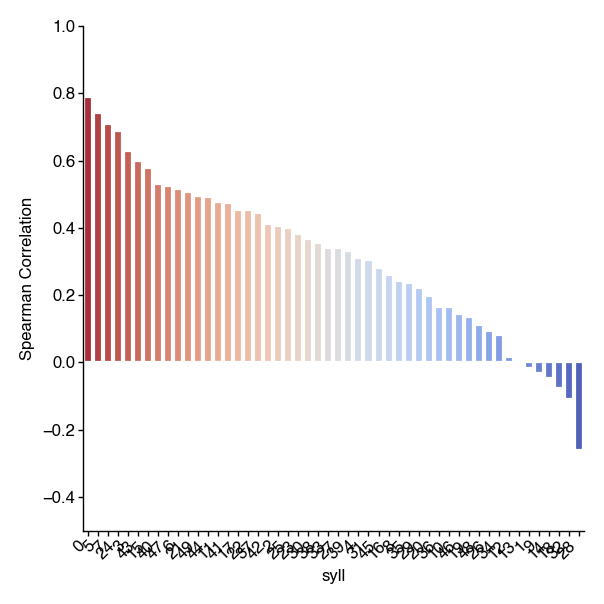

In [10]:
# Create a DataFrame from the correlation values list
corr_df = pd.DataFrame(correlation_matrix, columns=['corr'])

# Sort the DataFrame by correlation values
corr_df = corr_df.sort_values(by='corr', ascending=False)
corr_df['syll'] = list(range(len(correlation_matrix)))
#corr_df['syll'] = corr_df.index.to_numpy()

# Plotting
fig, ax = plt.subplots()
fig.set_size_inches(3,3)
sns.barplot(x='syll', y='corr', data=corr_df, dodge=True, palette ="coolwarm_r" )
plt.xticks(rotation=45, ha='right')
#plt.title('Spearman Correlation between Columns of df1 and df2')
#plt.xlabel('Columns in df1')
plt.ylim([-0.5,1])
plt.ylabel('Spearman Correlation')
ax.set_xticklabels(corr_df.index.to_numpy())
plt.tight_layout()
sns.despine()
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig4"/ 'fvm_syll_change_over_life_crosscorr.pdf')

In [11]:
# Calculate p-values using scipy's pearsonr function
from scipy.stats import spearmanr
correlation_matrix = m_data.corrwith(f_data, axis=0, method='spearman')

p_values = m_data.apply(lambda col: spearmanr(col, f_data[col.name])[1])*50 #change by number of syllables used

#colors = ['purple' if value > 0 else 'orange' for value in new_diff]

# Combine results into a DataFrame
result_df = pd.DataFrame({'Correlation': correlation_matrix, 'P-Value': p_values})

print(result_df)

    Correlation    P-Value
46     0.788312   0.001095
5     -0.016883  47.104810
11     0.406494   3.372909
0      0.627273   0.116864
3      0.309091   8.638414
12     0.740260   0.006232
20     0.515584   0.837322
32     0.707792   0.016572
13     0.241558  14.573538
4     -0.031169  44.665409
33     0.164935  23.747078
28     0.477922   1.421651
43     0.015584  47.327198
9      0.003896  49.331368
19    -0.045455  42.244417
38     0.579221   0.296587
40     0.261039  12.653241
39     0.454545   1.921971
7     -0.076623  37.065569
48     0.135065  27.970076
34     0.196104  19.712083
23     0.506494   0.956448
26     0.451948   1.985101
49     0.383117   4.323915
18     0.687013   0.029049
41     0.398701   3.670404
15     0.094805  34.135351
35     0.340260   6.561879
17    -0.259740  12.775957
8      0.220779  16.809404
1      0.367532   5.059951
36     0.303896   9.023884
16    -0.109091  31.892215
21     0.341558   6.483893
29     0.080519  36.431201
2      0.235065  15.251514
2

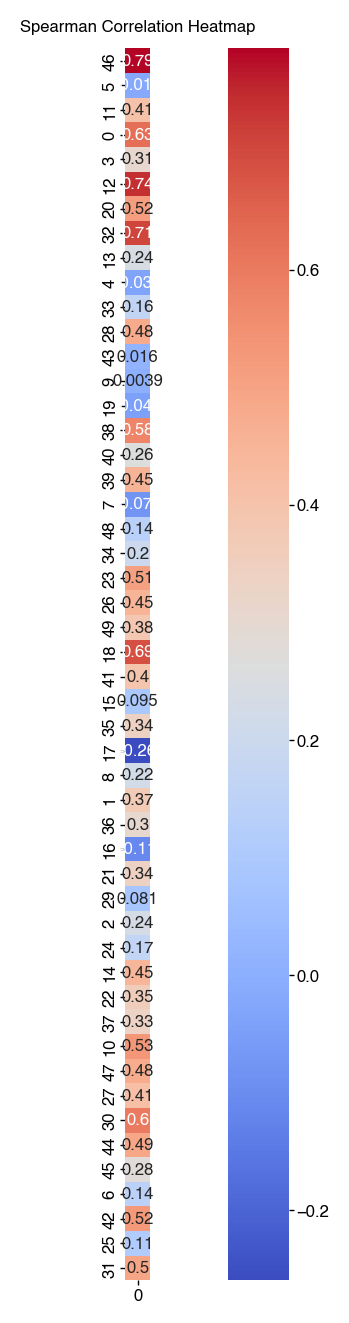

In [12]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix.to_frame(), annot=True, cmap="coolwarm", cbar=True, square=True)
plt.title("Spearman Correlation Heatmap")
plt.show()